In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import differential_evolution, basinhopping
import warnings
import os
warnings.filterwarnings('ignore')

# <center>European Option Pricing Based on Heston-Dupire</center>
### <center>Group 8: Gong Jiaxin, Zou Xuyuan</center>
# 1. Theory
## 1.1 Heston-Dupire Model
<font size=2 >The Heston-Dupire immediate local volatility model is a model that combines the local volatility obtained from the Dupire formula in its unparameterized form with the Heston stochastic volatility model.
</font>
$$
d S_t=r S_t d t+L\left(t, S_t\right) \sqrt{V_t} S_t d W_{1 t}
$$

$$
d V_t=a\left(b-V_t\right) d_t+\sigma_v \sqrt{V_t} d W_{2 t}
$$


## 1.2 Leverage function

### 1.2.1 Derivation of leverage function
<font size=2> Let the price of the European call option be　</font>


$$
C(t, K)=\frac{B_{t_0}}{B_t} E\left[\left(S_t-K\right)^{+}\right]
$$
<font size=2> Differentiating the the above equation, and using Fubini's theorem, we get, </font>
$$
d C(t, K)=-\frac{r}{M_t} E\left[\left(S_t-K\right)^{+}\right] d t+\frac{1}{M_t} E\left[d\left(S_t-K\right)^{+}\right]
$$
<font size=2> This function is not differentiable at x =  c  and cannot be solved directly by Itoˆ 's lemma. However, this problem can be solved by the following Tanaka-Meyer formula. </font>
$$
g\left(X_t\right)=g\left(X_{t_0}\right)+\int_{t_0}^t 1_{X_u>b} d \tilde{B}_u+\int_{t_0}^t 1_{X_u>b} d V_u+\frac{1}{2} \int_{t_0}^t g^{\prime \prime}\left(X_u\right)\left(d \tilde{B}_u\right)^2
$$
<font size=2> To further simplify the calculation, the well-known conclusion from Feng (2010) can be used.  If S<sub>t</sub>, V<sub>t</sub>  obey the stochastic local volatility model in 1.1, then the following equation holds for the price of a European call option.</font>
$$
-\frac{\partial C(t, K)}{\partial K}=\frac{1}{B_t} E\left[1_{S_t>K}\right], \frac{\partial C^2(t, K)}{\partial K^2}=\frac{\psi_S}{B_t}
$$

$$
L^2(t, K)=\frac{\frac{\partial C(t, K)}{\partial t}+r K \frac{\partial C(t, K)}{\partial K}}{\frac{1}{2} K^2 \frac{\partial^2 C(t, K)}{\partial K^2} E\left[V_t \mid S_t=K\right]}=\frac{\sigma_{L V}^2(t, K)}{E\left[V_t \mid S_t=K\right]}
$$


### 1.2.2 Calculation of leverage function
### Numerator

$$
\begin{aligned}
E\left[V_{t_{i}} \mid S_{t_{i}}=s_{i, j}\right] & \approx \frac{E\left[V_{t_{i}} \mathbb{1}_{S_{t_{i}} \in\left(b_{i, k}, b_{i, k+1}\right]}\right]}{\mathbb{Q}\left[S_{t_{i}} \in\left(b_{i, k}, b_{i, k+1}\right]\right]} \\
& \approx \frac{\frac{1}{M} \sum_{j=1}^{M} v_{i, j} \mathbb{1}_{s_{i, j} \in\left(b_{i, k}, b_{i, k+1}\right]}}{\mathbb{Q}\left[S_{t_{i}} \in\left(b_{i, k}, b_{i, k+1}\right]\right]} \\
& \approx \frac{l}{M} \sum_{j \in \mathscr{f}_{i, k}} v_{i, j}
\end{aligned}
$$

### Denominator

$$
\sigma_{L V}^2(T, K)=\frac{\sigma_I^2+2 T \sigma_I\left(\frac{\partial \sigma_I}{\partial T}+r K \frac{\partial \sigma_I}{\partial K}\right)}{\left(1+d_1 K \sqrt{T} \frac{\partial \sigma_l}{\partial K}\right)^2+K^2 \sigma_I T\left(\frac{\partial^2 \sigma_I}{\partial K^2}-d_1 \sqrt{T}\left(\frac{\partial \sigma_l}{\partial K}\right)^2\right)}
$$

<font size=2> To get σ<sub>I</sub>  We first use the SVI (Stochastic Volatility Inspired) function to fit in the K-direction , followed by linear interpolation in the T-direction. And then we obtain the implied volatility surface by combining the two directions.
</font>
$$
\sigma_{I}^{S V I}=\sqrt{\frac{\alpha_{n}+\beta_{n}\left[\rho_{n}\left(x-m_{n}\right)+\sqrt{\left(x-m_{n}\right)^{2}+\sigma_{n}}\right]}{T_{n}}}
$$

$$
\min J_n(\boldsymbol{C})=\frac{1}{2} \sum_{i=1}^M w_i\left(\frac{\sigma_I^{S V I}\left(T_n, K_i ; \boldsymbol{C}\right)-\sigma_I^{\text {Market }}\left(T_n, K_i\right)}{\sigma_I^{\text {Market }}\left(T_n, K_i\right)}\right)^2
$$

$$
\sigma_I^{S V I}(T, x)=\frac{T_{n+1}-T}{T_{n+1}-T_n} \sigma_I^{S V I}\left(T_n, x\right)+\frac{T-T_n}{T_{n+1}-T_n} \sigma_I^{S V I}\left(T_{n+1}, x\right)
$$

<font size=2> To complete the calculation of the rest of leverage function, we take the numerical derivatives by difference.
</font>
$$
\begin{aligned}
\sigma_{I} & =\sigma_{I}^{S V I}(T, x)=\lambda_{n} \sigma_{I}^{S V I}\left(T_{n}, x\right)+\lambda_{n+1} \sigma_{I}^{S V I}\left(T_{n+1}, x\right) \\
\frac{\partial \sigma_{I}}{\partial T} & =\frac{1}{T_{n+1}-T_{n}}\left[\sigma_{I}^{S V I}\left(T_{n+1}, x\right)-\sigma_{I}^{S V I}\left(T_{n}, x\right)\right] \\
\frac{\partial \sigma_{I}}{\partial x} & =\tau_{n} f_{n}^{(1)}+\tau_{n+1} f_{n+1}^{(1)} \\
\frac{\partial^{2} \sigma_{I}}{\partial x^{2}} & =\tau_{n} f_{n}^{(2)}+\tau_{n+1} f_{n+1}^{(2)}
\end{aligned}
$$


# 2. Practice
## 2.1 Fitting volatility based on SVI
<font size=2> We select the CSI 300 put option data on December 29, 2023, and fit the implied volatility surface using the SVI method.
</font>


In [2]:
os.chdir(r'./volatility_data')

In [3]:
pricecsi300 = pd.read_excel(r"./index_sequence.xlsx")
pricecsi300

,Unnamed: 0,收盘价_x000D_\n[单位] 元,开盘价_x000D_\n[单位] 元,最高价_x000D_\n[单位] 元,最高价_x000D_\n[单位] 元.1,结算价_x000D_\n[单位] 元
0,时间,沪深300,沪深300,沪深300,沪深300,沪深300
1,2023-01-03 00:00:00,3887.8992,3864.8356,3893.9904,3893.9904,NaN
2,2023-01-04 00:00:00,3892.9477,3886.2504,3905.9032,3905.9032,NaN
3,2023-01-05 00:00:00,3968.5782,3913.4928,3974.875,3974.875,NaN
4,2023-01-06 00:00:00,3980.8888,3969.5493,4000.4143,4000.4143,NaN
...,...,...,...,...,...,...
306,2024-04-10 00:00:00,3504.7086,3528.9679,3531.2295,3531.2295,NaN
307,2024-04-11 00:00:00,3504.2447,3485.0294,3520.5893,3520.5893,NaN
308,2024-04-12 00:00:00,3475.8389,3505.7499,3516.6988,3516.6988,NaN
309,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
data = pd.read_excel(r".\20231229_sell\波动率曲面.xlsx")
data

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31
0,到期,到期日,合成期货,2900.00,2950.00,3000.00,3050.00,3100.00,3150.00,3200.00,...,3850.00,3900.00,3950.00,4000.00,4100.00,4200.00,4300.00,4400.00,4500.00,4600.00
1,1M,20240128,3444.363,24.04,22.96,21.89,20.77,19.61,18.35,17.18,...,21.90,23.02,24.21,25.26,27.37,29.48,31.59,33.69,35.80,37.91
2,2M,20240228,3457.701,22.07,21.16,20.26,19.39,18.55,17.91,17.33,...,20.46,20.98,21.79,22.59,23.93,25.54,26.73,28.03,29.62,31.21
3,3M,20240328,3464.046,21.50,20.67,19.83,19.12,18.54,17.86,17.35,...,19.93,20.43,21.17,21.90,22.98,24.45,25.34,26.46,27.92,29.39
4,6M,20240628,3469.154,19.15,18.66,18.16,17.84,17.53,17.25,16.97,...,17.91,18.28,18.73,19.19,19.99,20.85,21.72,22.89,23.90,24.90
5,9M,20240928,3464.497,18.55,18.27,17.99,17.77,17.55,17.32,17.09,...,17.21,17.44,17.70,17.97,18.26,18.76,19.25,19.74,20.24,20.73
6,1Y,20241228,3486.69,17.98,17.83,17.68,17.50,17.32,17.15,16.99,...,16.36,16.18,16.00,15.81,15.45,15.09,14.73,14.37,14.00,13.64


In [17]:
from SVI import OptSVI1test
dataarr = data.values
K = dataarr[0,3:]
TT = [20, 40, 60, 120,180, 250]
S = dataarr[1:, 2]
w = np.ones((6, 30))  # weights for each option
Vol = np.array(dataarr[1:,3:]) * 0.01


In [19]:

p = np.ones((6, 5)) * 0.0 # initial guess for SVI parameters
p[4:,:] = 0.003
for i in range(6):
    S0 = 3431.1099
    fun = lambda p: OptSVI1test(i, Vol, w, p, K, S0, TT)
    res = basinhopping(fun, p[i,:],niter=1500)
    p[i,:] = res.x
print(p)
# np.save('para_svi.npy',p)

[[-2.22916031e-01  2.67170948e-01 -3.95196490e-01 -4.09691800e-01
   8.40313759e-01]
 [-9.41653759e-02  1.91581015e-01 -3.75423485e-01 -2.43779911e-01
   3.08932183e-01]
 [-1.32221218e-02  8.74635368e-02  1.15395357e-02 -8.43610732e-03
   5.21284008e-02]
 [-5.84196830e-01  9.03288821e-01  7.12118553e-01  9.55271002e-01
   8.87370070e-01]
 [-5.18106744e-01 -1.96948604e-01 -1.75946067e+00 -2.29533167e+00
  -3.56054586e+00]
 [ 1.29992715e-01  2.52411409e-02  1.54042509e+00  3.65554297e+00
  -1.07389789e+01]]


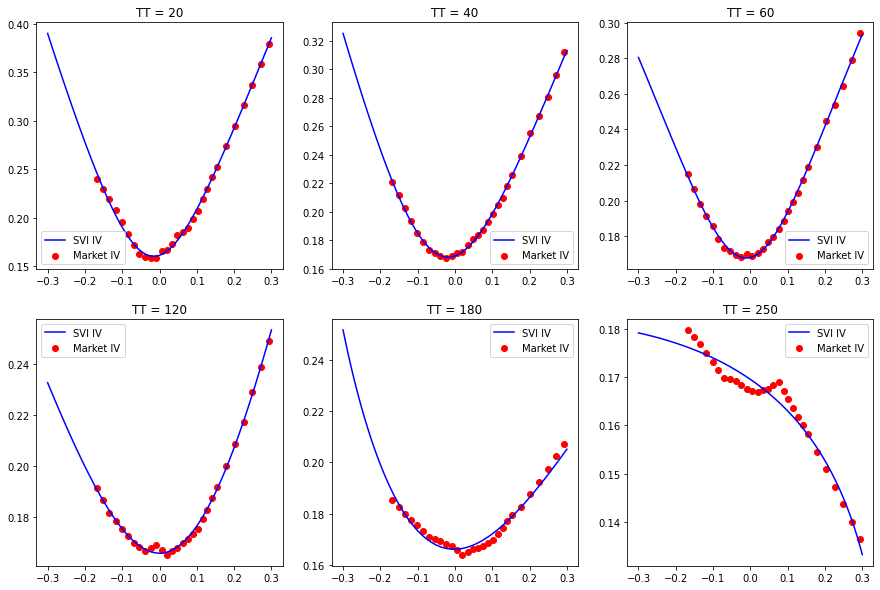

In [20]:
p = np.load('para_svi.npy')
fig, ax = plt.subplots(2, 3, figsize=(15, 10))  # 创建一个2x3的子图网格
for i in range(6):
    S0 = 3431.1099
    f = lambda x: np.sqrt(np.maximum(p[i, 0] + p[i, 1] * (p[i, 2] * (x - p[i, 3]) + np.sqrt((x - p[i, 3]) ** 2 + p[i, 4])), 0)) / np.sqrt(TT[i] / 250)
    x = np.linspace(-0.3, 0.3, 100)
    ax[i//3, i%3].plot(x, f(x),label = 'SVI IV', color='b')  # 选择子图
    ImpVol = Vol[i,:]
    x = np.array(K / S0).astype(float)
    ax[i//3, i%3].scatter(np.log(x), ImpVol,label='Market IV',color='r')
    ax[i//3, i%3].set_title('TT = %d' % TT[i])
    ax[i//3, i%3].legend()
    
plt.show()
fig.savefig('subplot.jpg')  # 保存整个子图网格为一个jpg文件

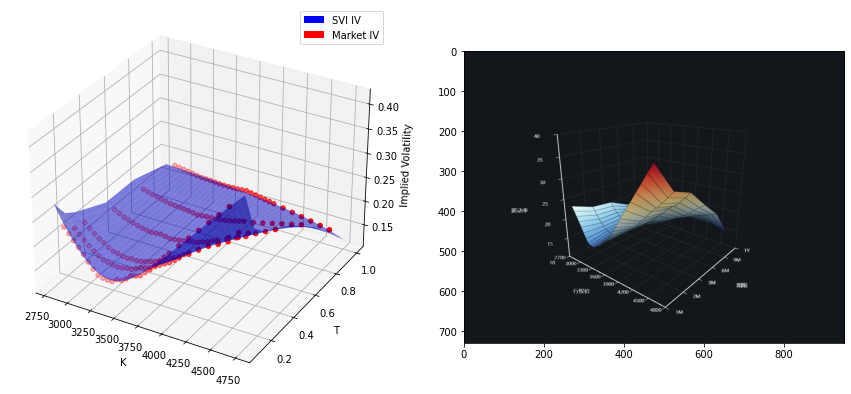

In [21]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.image import imread

# Create a figure with two subplots, one of which is a 3D plot
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122)

Z = []
for i in range(6):
    f = lambda x: np.sqrt(np.maximum(p[i, 0] + p[i, 1] * (p[i, 2] * (x - p[i, 3]) + np.sqrt((x - p[i, 3]) ** 2 + p[i, 4])), 0)) / np.sqrt(TT[i] / 250)
    x = (np.arange(2800, 4800, 50) / S0)
    Z.append(f(np.log(x)))

X, Y = np.meshgrid(np.arange(2800, 4800, 50),np.array(TT) / 250)
ax.plot_surface(X, Y, np.array(Z), alpha=0.5, color='blue')

xx = np.array(TT) / 250
ax.scatter(K, np.ones(len(K))*xx[0], Vol[0,:], color='red')
ax.scatter(K, np.ones(len(K))*xx[1], Vol[1,:], color='red')
ax.scatter(K, np.ones(len(K))*xx[2], Vol[2,:], color='red')
ax.scatter(K, np.ones(len(K))*xx[3], Vol[3,:], color='red')
ax.scatter(K, np.ones(len(K))*xx[4], Vol[4,:], color='red')
ax.scatter(K, np.ones(len(K))*xx[5], Vol[5,:], color='red')

ax.set_xlabel('K')
ax.set_ylabel('T')
ax.set_zlabel('Implied Volatility')

legend_elements = [Patch(facecolor='blue', label='SVI IV'),
                   Patch(facecolor='red', label='Market IV')]
ax.legend(handles=legend_elements)

# Load image from local file
img = imread(r'./20231229_sell/波动率曲面.png')

# Display the image
ax2.imshow(img)

plt.show()
fig.savefig('surface.jpg')

## 2.2 Model result
* <font size=2> strike = np.arange(2900, 3500, 50) </font>
* <font size=2>sigma, vov, mr, rho, texp, spot = 0.3, 1, 0.5, -0.9, 20, 3431.1099 </font>
### 2.2.1 Heston model



* <font size=2> Conditional MC for Heston model based on QE discretization scheme by Andersen (2008)</font>



In [2]:
import numpy as np
import pyfeng as pf
# sigma: model volatility or variance at t=0.
# vov: volatility of volatility
# rho: correlation between price and volatility
# mr: mean-reversion speed (kappa)
# theta: long-term mean of volatility or variance. If None, same as sigma
# intr: interest rate (domestic interest rate)
# divr: dividend/convenience yield (foreign interest rate)
# is_fwd: if True, treat `spot` as forward price. False by default.
strike = np.arange(2900, 3500, 50)
sigma, vov, mr, rho, texp, spot = 0.5, 1, 0.5, -0.9, 20, 3431.1099

m = pf.HestonMcAndersen2008(sigma, vov=vov, mr=mr, rho=rho)
m.set_num_params(n_path=1e5, dt=1/8, rn_seed=123456)
m.price(strike, spot, texp)

array([2614.7557097 , 2605.5777012 , 2596.47637983, 2587.45031286,
       2578.49811439, 2569.61844314, 2560.81000035, 2552.07152782,
       2543.40180606, 2534.79965257, 2526.2639202 , 2517.79349561])

* <font size=2> Heston model option pricing with FFT  Lewis AL (2000) Option valuation under stochastic volatility: with Mathematica code. Finance Press</font>

In [3]:
m = pf.HestonFft(sigma, vov=vov, mr=mr, rho=rho)
m.price(strike, spot, texp)

array([2628.65334821, 2619.48966579, 2610.40231646, 2601.38987433,
       2592.45096014, 2583.58423907, 2574.78841859, 2566.06224659,
       2557.40450947, 2548.81403046, 2540.28966797, 2531.83031408])

* <font size=2> Milstein for Heston</font>

In [24]:
# Milstein for Heston
r = 0.0
paths =100000
steps = 160
from heston import generate_heston_paths
prices_neg  = generate_heston_paths(spot, texp, r, mr, sigma,
                                     rho=rho, vov=vov, steps=steps, Npaths=paths,
                                    return_vol=False)[:,-1]  

calls = [] 
for K in strike:
    P = np.mean(np.maximum(prices_neg - K,0))*np.exp(-r*texp)
    calls.append(P)
print(np.array(calls))

[2588.3889053  2579.35324418 2570.39391599 2561.50654925 2552.6974709
 2543.95942172 2535.28801316 2526.68473049 2518.15106307 2509.68248496
 2501.27981974 2492.95075096]


### 2.2.1 Heston-Dupire model

* <font size=2> Var calculation is based on QE method, and we use Euler method to obtain ST </font>

$$
X_{t+dt} =  X_t + \left(r-\frac{1}{2} L^{2}\left(t, e^{X_{t}}\right) V_{t}\right) d t+L\left(t, e^{X_{t}}\right) \sqrt{V_{t}} d W_{1 t}
$$

In [25]:
# QE for Heaton-Dupire
from heston_mc import HestonMcAndersen2008 # we alter thie file
m = HestonMcAndersen2008(sigma, vov=vov, mr=mr, rho=rho)
m.set_num_params(n_path=1e5, dt=1/8, rn_seed=123456)
m.price(strike, spot, texp)
print('end')

100%|████████████████████████████████████████████████████████████████████████████████| 159/159 [12:38<00:00,  4.77s/it]


Heston-Dupire:  [574.08437613 558.31437139 542.96737848 528.08087414 513.67470773
 499.80181511 486.51445111 473.83205918 461.79139787 450.4427644
 439.77928339 429.82440945]
end


* <font size=2> Milstein for Heston-Dupire </font>

$$v_{t+dt} = v_t + \kappa (\theta - v_t) dt + \sigma \sqrt{v_t} dt Z_v + \frac{1}{4} \sigma^2 dt (Z_v^2 - 1)$$
$$ X_{t+dt} =  X_t + \left(r - \frac{1}{2} v_t{L_t}^2\right) dt + \sqrt{v_t}L_t dt Z_s$$



In [7]:
# Milstein for Heston-Dupire
from hestondupire import generate_hestondupire_paths
r = 0.0
paths =int(1e5)
steps = 160
prices_neg  = generate_hestondupire_paths(spot, texp, r, mr, sigma,
                                     rho=rho, vov=vov, steps=steps, Npaths=paths,
                                    return_vol=False)[:,-1]  

calls = [] 
for K in strike:
    P = np.mean(np.maximum(prices_neg - K,0))*np.exp(-r*texp)
    calls.append(P)
print(calls)

100%|████████████████████████████████████████████████████████████████████████████████| 159/159 [12:33<00:00,  4.74s/it]

[543.0012140365923, 527.5087182695403, 512.4369276030873, 497.7983599724606, 483.6405010650162, 469.9989355729829, 456.9234524661498, 444.458064480143, 432.6333222533259, 421.4505778410579, 410.9189585735541, 401.04508534373315]
